# Source Code Analysis

## Initialization

In [1]:
import os
import sys

def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)
        sys.path.append(path)
# add_path('/home/jjian03/anaconda3/lib/python3.7/site-packages')
# add_path(f'{os.path.abspath(os.path.join("."))}/lib')


### Load Data

In [2]:
import time
import datetime
import pandas as pd

seed = 77

data_file = 'untrunc_data_cleaned_url.csv'

raw_data = pd.read_table(data_file, sep=',', index_col=0)
raw_data = raw_data.dropna()

raw_data.info()

print(f'raw_data: {raw_data.shape}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58875 entries, 0 to 58911
Data columns (total 42 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   protocol_type                           58875 non-null  float64
 1   has_www                                 58875 non-null  float64
 2   has_iframe                              58875 non-null  float64
 3   int                                     58875 non-null  float64
 4   org                                     58875 non-null  float64
 5   gov                                     58875 non-null  float64
 6   in                                      58875 non-null  float64
 7   eu                                      58875 non-null  float64
 8   cn                                      58875 non-null  float64
 9   kr                                      58875 non-null  float64
 10  url_depth                               58875 non-null  fl

### Train Test Split

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


x = raw_data.drop(['label', 'first_appear'], axis=1)
y = raw_data.label
y = preprocessing.StandardScaler().fit_transform(y.values.reshape(-1, 1))
y = pd.DataFrame(y).iloc[:,0]


X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.33, random_state=seed)

### Correlation Heatmap

In [4]:
import math, scipy, numpy as np, seaborn as sns, matplotlib.pyplot as plt
%matplotlib inline

x_dead = x[raw_data.label < 30]
x_alive = x[raw_data.label >= 30]


def heatmap(data, significant_level, title):
    corr = data.corr()
    plt.clf()
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 20))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(20, 230, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

    idx_map = dict((col_name, idx + 0.5) for idx, col_name in enumerate(corr.index.tolist()))
    corr_flat = pd.melt(corr.reset_index(), id_vars='index').replace(np.nan, 0)
    corr_flat.columns = ['x', 'y', 'value']
    corr_flat.loc[:, 'x_idx'] = corr_flat.x.map(idx_map)
    corr_flat.loc[:, 'y_idx'] = corr_flat.y.map(idx_map)
    corr_flat = corr_flat[corr_flat.x_idx < corr_flat.y_idx]
    corr_flat.loc[:, 'p'] = None
    corr_flat.loc[:, 'p'] = corr_flat.apply(lambda row: scipy.stats.pearsonr(corr[row[0]], corr[row[1]])[1], axis=1)

    corr_flat = corr_flat[corr_flat.p <= significant_level/2]# 2-tailed p-value

    ax.scatter(corr_flat.x_idx, corr_flat.y_idx,
               marker='o',
               s=50,
               color='black',
               label='p value < 5%') 
    ax.legend()


    plt.title(title, size=30)
    plt.show()


<Figure size 432x288 with 0 Axes>

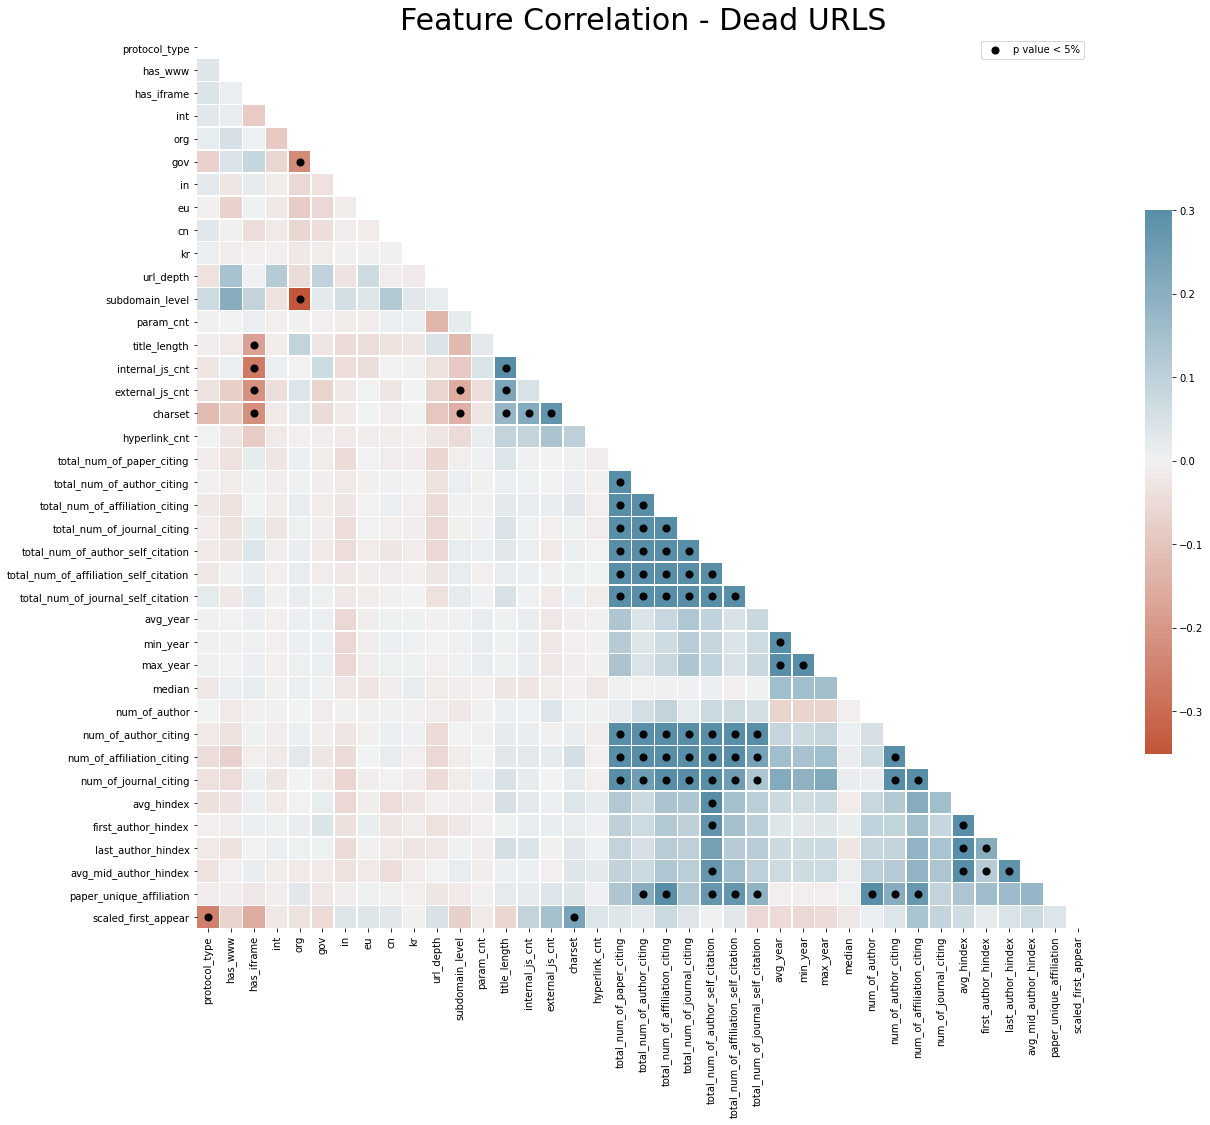

In [5]:
heatmap(x_dead, significant_level=.05, title='Feature Correlation - Dead URLS');


<Figure size 432x288 with 0 Axes>

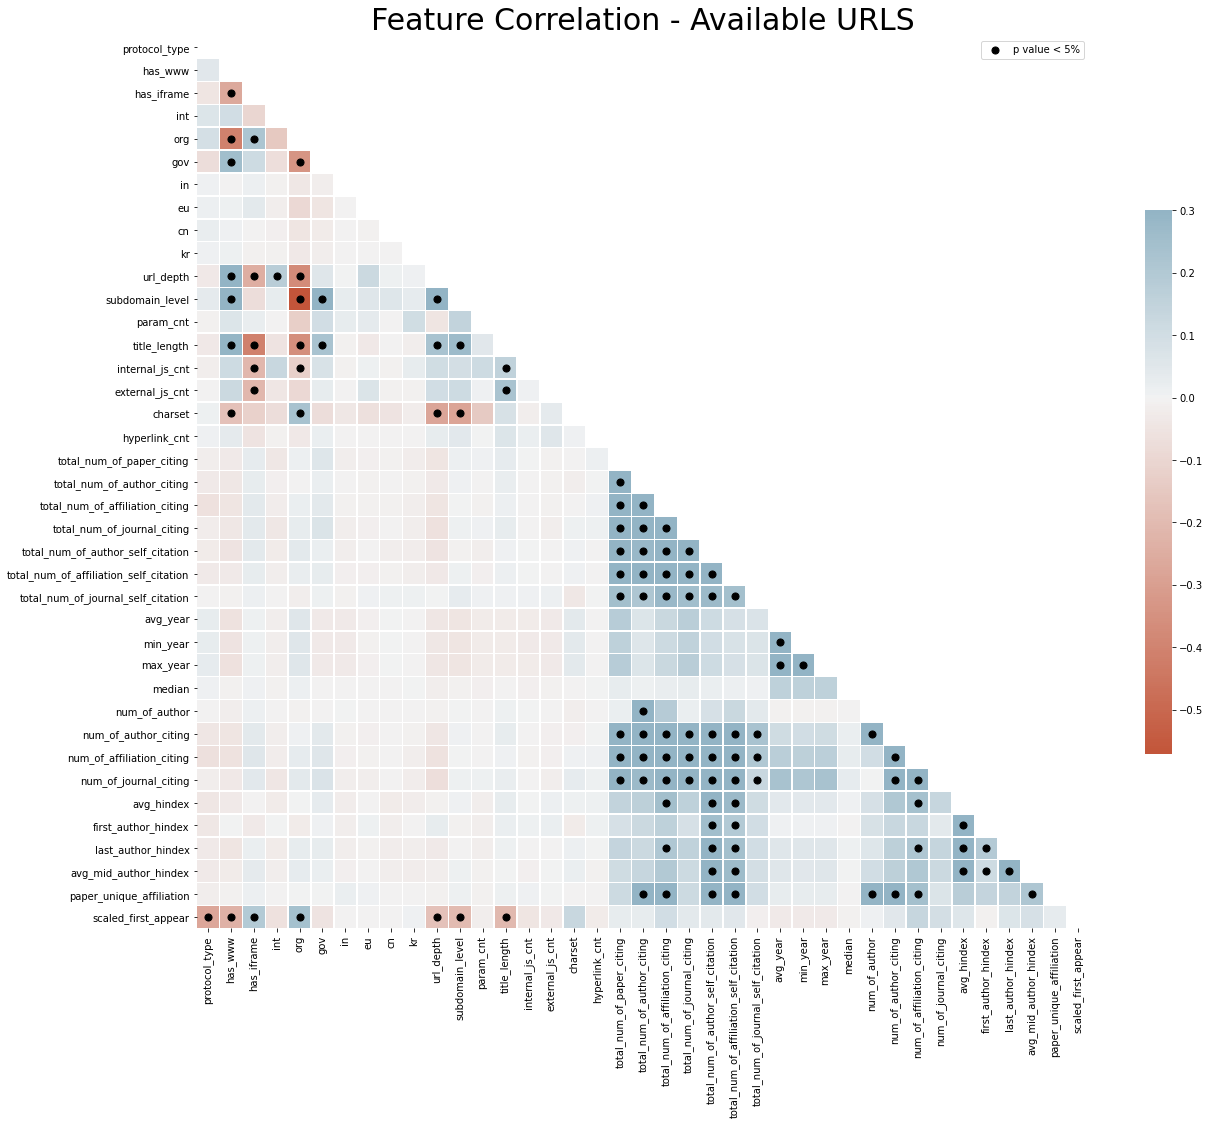

In [6]:
heatmap(x_alive, significant_level=.05, title='Feature Correlation - Available URLS');

### Weighted heatmap

In [7]:
from collections import Iterable
import pandas as pd


def heatmap(x, y, title, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order', 'xlabel', 'ylabel'
    ]}

    size_legend = np.round(1/size.apply(lambda p: 10**p), 1)
    bins = np.array([1e-7, .001, .1, 1])
    size_legend_idx = np.digitize(size_legend, bins,right=True)
    bin_label = pd.Series(bins).apply(lambda x: f'< {x}')
    size_lable = bin_label.iloc[size_legend_idx].tolist()

#     if not isinstance(marker, Iterable):
#         marker = [marker] * len(x)

    df = pd.DataFrame({
        'x':[x_to_num[v] for v in x],
        'y':[y_to_num[v] for v in y],
        's':[value_to_size(v) for v in size],
        'c':[value_to_color(v) for v in color],
        'label':size_lable,
    })
    grouped = df.groupby(size_legend_idx)
    for i, (name, group) in enumerate(grouped):
        ax.scatter(
            x=group.x,
            y=group.y,
            marker=marker,
            s=group.s,
            c=group.c,
            label=size_lable[i],
            **kwargs_pass_on
        )

    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    ax.set_xlabel(kwargs.get('xlabel', ''))
    ax.set_ylabel(kwargs.get('ylabel', ''))

    if title:
        ax.set_title(title, size=30)

    ax.legend(bin_label[[name for i, (name, group) in enumerate(grouped)]])
    leg = ax.get_legend()
    leg.set_title('P-value',prop={'size':14})
    for handle in leg.legendHandles:
        handle.set_color('black')


    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 5)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right


def corrplot(data, size_scale=500, marker='s', title=None):
    plt.clf()
    plt.figure(figsize=(20, 20))
    idx_map = dict((col_name, idx) for idx, col_name in enumerate(data.index.tolist()))
    corr = pd.melt(data.reset_index(), id_vars='index').replace(np.nan, 0)
    corr.columns = ['x', 'y', 'value']
    corr.loc[:, 'x_ind'] = corr.x.map(idx_map)
    corr.loc[:, 'y_ind'] = corr.y.map(idx_map)
    corr = corr[corr.x_ind < corr.y_ind]
    corr.loc[:, 'p'] = None
    corr.loc[:, 'p'] = corr.apply(lambda row: scipy.stats.pearsonr(data[row[0]], data[row[1]])[1], axis=1)
    size = (1/corr['p']).apply(math.log10)
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 230, n=256),
        size=size, size_range=[min(size), max(size)],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        title=title,
        size_scale=size_scale
    )


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  """Entry point for launching an IPython kernel.


<Figure size 432x288 with 0 Axes>

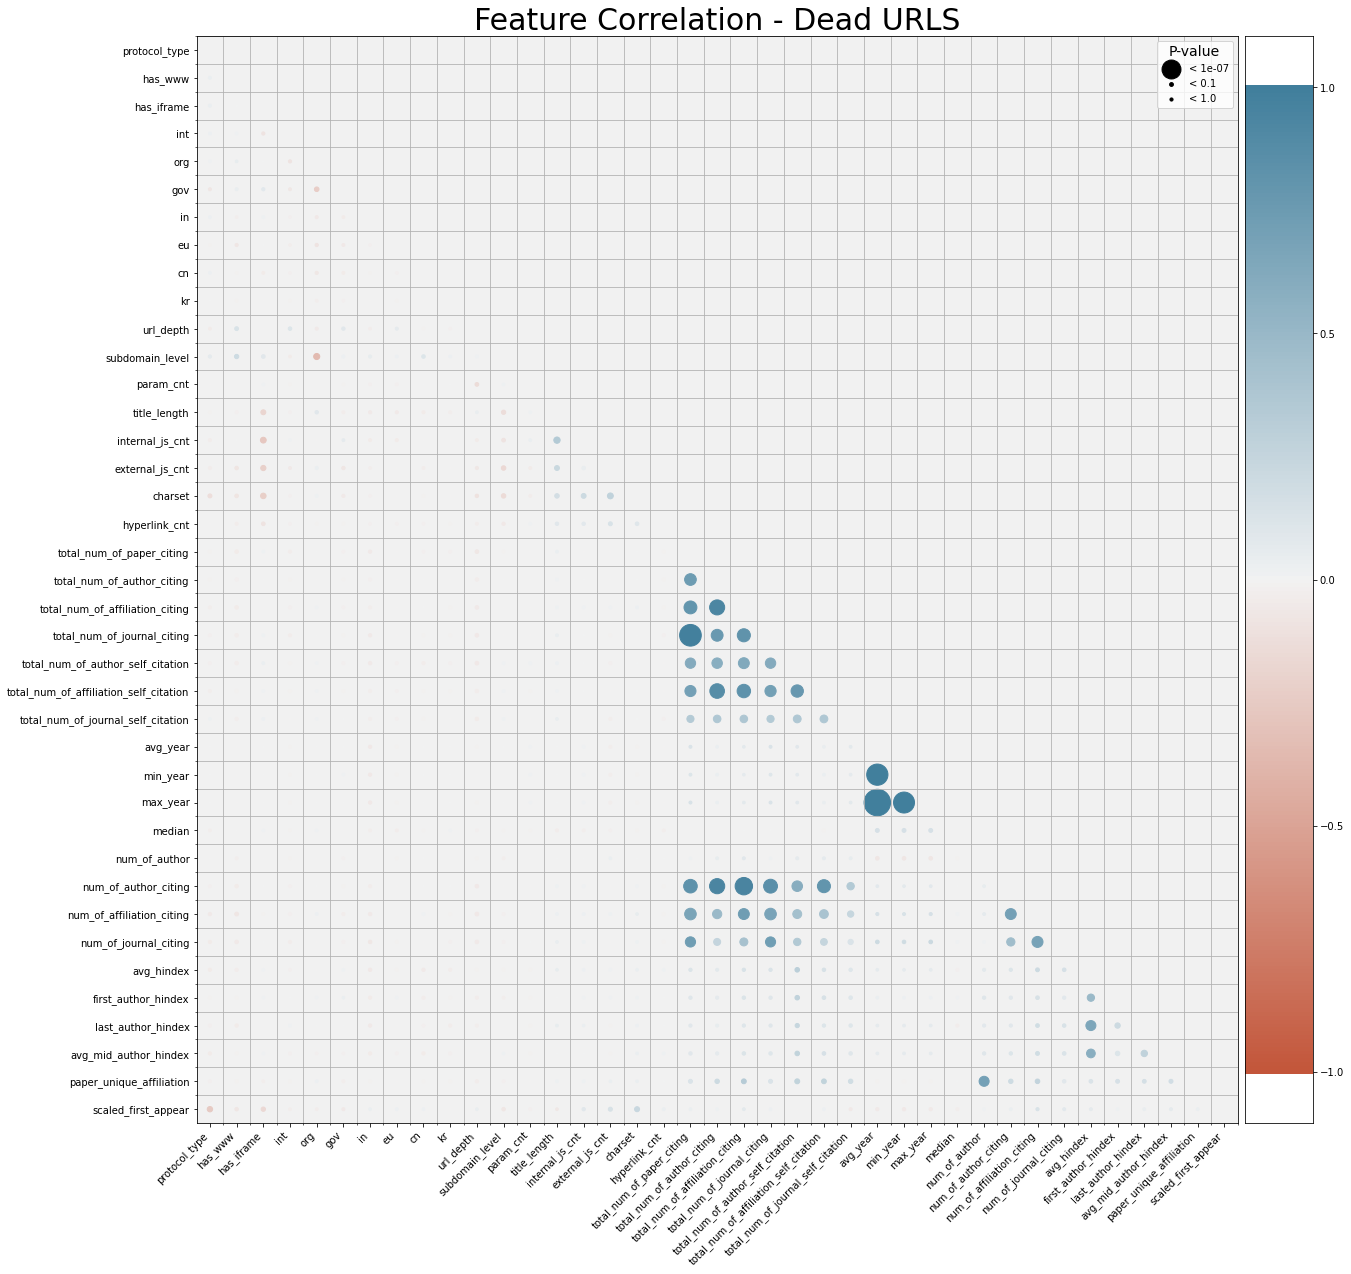

In [8]:
corrplot(x_dead.corr(), marker='o', size_scale=700, title='Feature Correlation - Dead URLS');


<Figure size 432x288 with 0 Axes>

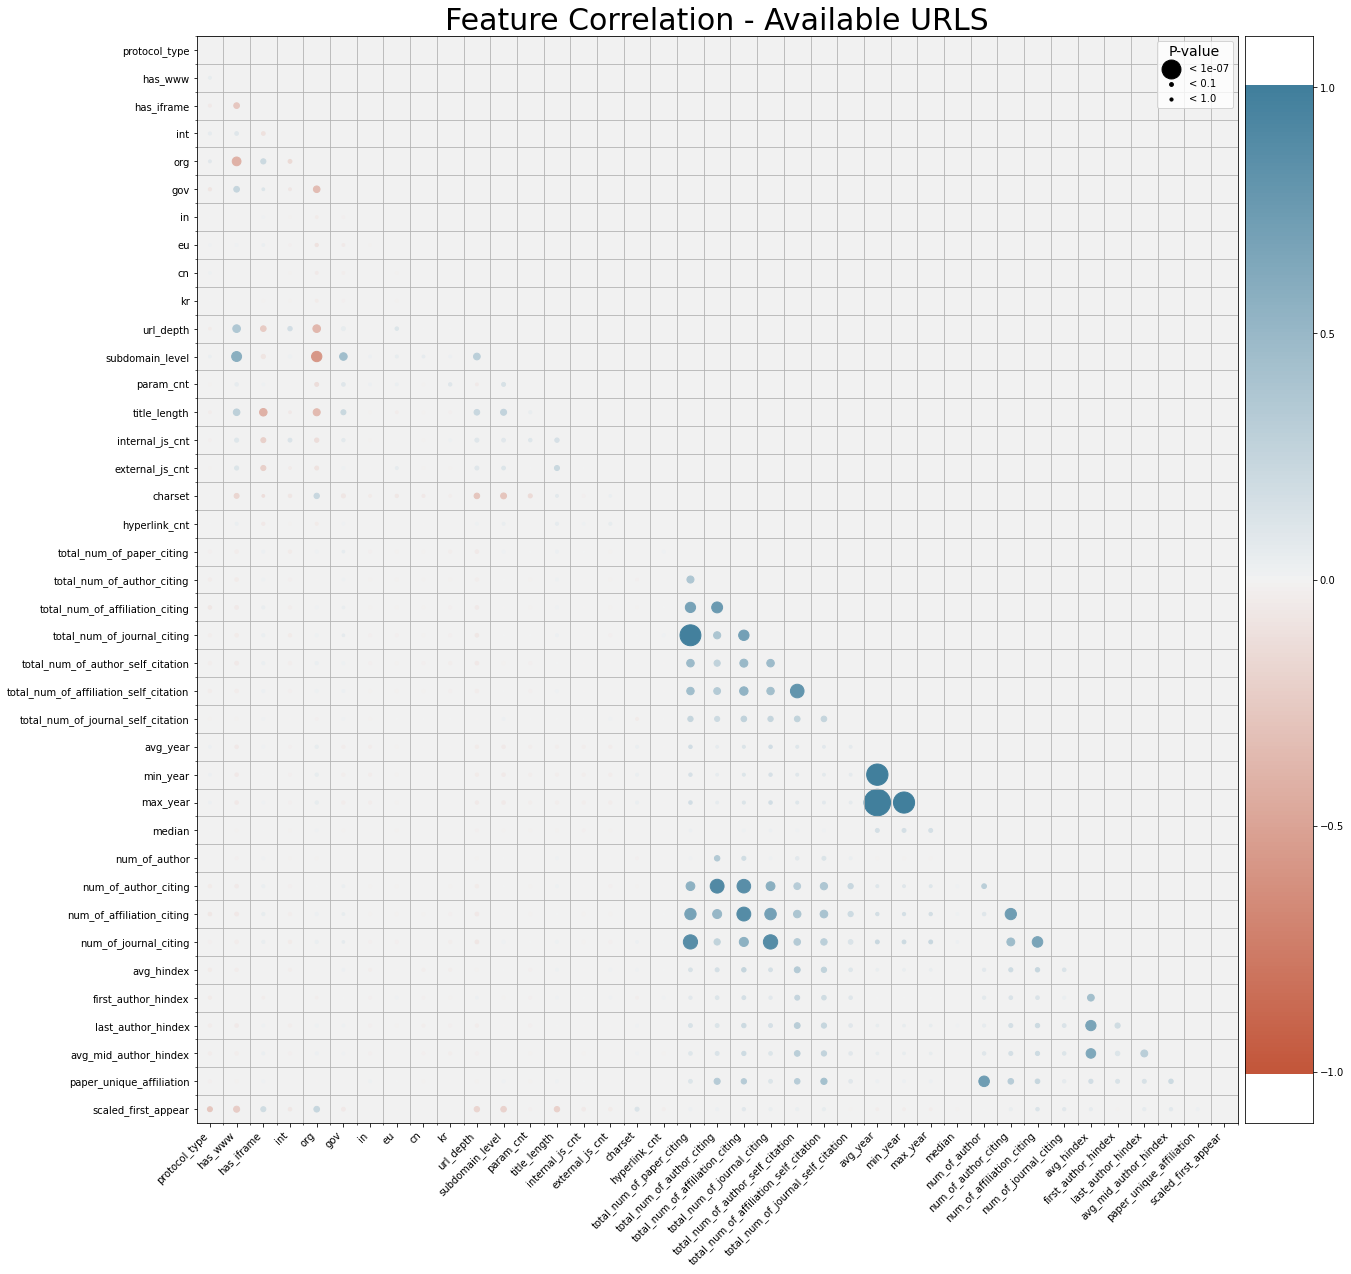

In [9]:
corrplot(x_alive.corr(), marker='o', size_scale=700, title='Feature Correlation - Available URLS');
